## Ethique: Estimation d'incertitude


In [104]:
# Import librairires

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy.typing import NDArray
from sklearn.neural_network import MLPRegressor
from mapie.metrics.regression import regression_coverage_score
from mapie.regression import SplitConformalRegressor
from mapie.utils import train_conformalize_test_split

RANDOM_STATE = 1

In [105]:
#Dataset Creation 
dfwine= pd.read_csv("wine.csv")

In [106]:
dfwine

,Grape,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,1.51,-0.56,0.23,-1.17,1.91,0.81,1.03,-0.66,1.22,0.25,0.36,1.84,1.01
1,1,0.25,-0.50,-0.83,-2.48,0.02,0.57,0.73,-0.82,-0.54,-0.29,0.40,1.11,0.96
2,1,0.20,0.02,1.11,-0.27,0.09,0.81,1.21,-0.50,2.13,0.27,0.32,0.79,1.39
3,1,1.69,-0.35,0.49,-0.81,0.93,2.48,1.46,-0.98,1.03,1.18,-0.43,1.18,2.33
4,1,0.29,0.23,1.84,0.45,1.28,0.81,0.66,0.23,0.40,-0.32,0.36,0.45,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,0.87,2.97,0.30,0.30,-0.33,-0.98,-1.42,1.27,-0.93,1.14,-1.39,-1.23,-0.02
174,3,0.49,1.41,0.41,1.05,0.16,-0.79,-1.28,0.55,-0.32,0.97,-1.13,-1.48,0.01
175,3,0.33,1.74,-0.39,0.15,1.42,-1.13,-1.34,0.55,-0.42,2.22,-1.61,-1.48,0.28
176,3,0.21,0.23,0.01,0.15,1.42,-1.03,-1.35,1.35,-0.23,1.83,-1.56,-1.40,0.30


## Principal Component Analysis (PCA)

In [107]:
alcohol = dfwine.pop('Alcohol')
X= dfwine


In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)

[0.41966049]


In [109]:
#### splitting train and test set
X = X_pca
y = alcohol
(X_train, X_conformalize, X_test, y_train, y_conformalize, y_test) = (
    train_conformalize_test_split(
        X,
        y,
        train_size=0.8,
        conformalize_size=0.1,
        test_size=0.1,
        random_state=RANDOM_STATE,
    )
)

In [110]:
#We fit our training data with a MLPRegressor.
#then , we initialize a splitConformaleRegressor using our estimato, indicating that it hasalready been fitted with prefit = True.
#Lastly, we compute the prediction intervals with the desired confidence level using the conformalize and predict_interval method.
regressor = MLPRegressor(activation="relu", random_state=RANDOM_STATE)
regressor.fit(X_train, y_train)

confidence_level = 0.90
mapie_regressor = SplitConformalRegressor(
    estimator=regressor, confidence_level=confidence_level, prefit=True
)
mapie_regressor.conformalize(X_conformalize, y_conformalize)
y_pred, y_pred_interval = mapie_regressor.predict_interval(X_test)

In [111]:
coverage_score = regression_coverage_score(y_test, y_pred_interval)
print(
    f"For a confidence level of {confidence_level:.2f}, "
    f"the target coverage is {confidence_level:.3f}, "
    f"and the effective coverage is {coverage_score[0]:.3f}."
)

For a confidence level of 0.90, the target coverage is 0.900, and the effective coverage is 0.947.


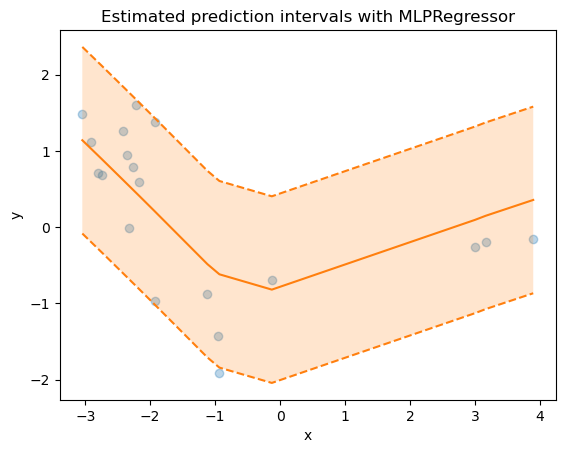

In [112]:
plt.xlabel("x")
plt.ylabel("y")


plt.scatter(X_test, y_test, alpha=0.3)
X_test = X_test.ravel()
order = np.argsort(X_test)

plt.plot(X_test[order], y_pred[order], color="C1")
plt.plot(X_test[order], y_pred_interval[order][:, 0, 0], color="C1", ls="--")
plt.plot(X_test[order], y_pred_interval[order][:, 1, 0], color="C1", ls="--")
plt.fill_between(
    X_test[order],
    y_pred_interval[:, 0, 0][order].ravel(),
    y_pred_interval[:, 1, 0][order].ravel(),
    alpha=0.2,
)
plt.title("Estimated prediction intervals with MLPRegressor")
plt.show()

In [113]:
X_test


array([-1.12034962, -0.93515643, -2.21293174, -1.92997208, -2.80791379,
       -2.16716039, -0.1291961 , -2.33282107,  3.89294746, -2.91688391,
       -2.4123277 , -3.04513241, -2.75003725,  3.1592645 , -2.36402265,
       -2.27244946, -0.95958691, -1.92479242,  2.99805808])